### Notebook Overview

In this notebook, we present the workflow, materials, methods, results, and discussion related to the development and evaluation of the KokoroBot chatbot. The notebook covers the following sections:

1. **Introduction**: Overview of KokoroBot and its purpose in providing empathetic interactions.
2. **Workflow**: Step-by-step workflow for developing and deploying KokoroBot.
3. **Dataset and Data Preprocessing**: Description of the dataset used for training the emotion detection model and the preprocessing steps taken to prepare the data.
4. **Model Architecture**: Detailed explanation of the CNN architecture used for emotion detection.
5. **Training and Evaluation**: Processes involved in training the model and evaluating its performance.
6. **LLM Integration**: Explanation of the integration of Google’s Gemini-Pro AI model for generating empathetic responses based on detected emotions and user input.
7. **Frontend Development**: Overview of the Streamlit-based frontend and custom CSS for a user-friendly interface.
8. **Results**: Presentation of the results from the emotion detection model and examples of chatbot interactions.
9. **Conclusion**: Implications of the findings and potential applications of KokoroBot in real-world scenarios.

The goal is to demonstrate the effectiveness and potential applications of KokoroBot in providing empathetic and supportive interactions based on real-time emotional analysis, leveraging both advanced emotion detection and sophisticated language generation capabilities.

### Introduction

Emotions are fundamental to human experience, influencing decisions, interactions, and well-being. They provide insights into our mental state and guide our behaviors. Understanding emotions enhances empathy, helps us navigate social interactions, and improves the quality of our relationships. Advances in AI and machine learning have enabled the development of models that recognize emotions from facial expressions with high accuracy, offering practical applications that improve lives.

### KokoroBot: An Empathetic Chatbot

KokoroBot is an AI-driven application designed to engage users in personalized conversations based on their emotional states. Named after the Japanese word "Kokoro," meaning "heart" or "mind," the bot aims to connect with users on an emotional level.

Built with Streamlit for the frontend, KokoroBot integrates Google's Gemini-Pro AI for response generation and TensorFlow for real-time emotion detection from webcam frames. The interface uses custom CSS for a visually appealing, user-friendly experience, maintaining chat history within the session state for context.

On the backend, OpenCV captures and processes webcam frames, while a TensorFlow CNN model classifies emotions like happiness, sadness, anger, and fear. This ensures accurate and fast emotion recognition. Users input messages through a text field; the chatbot captures and processes a webcam frame, feeds it into the TensorFlow model, and generates empathetic responses using the Gemini-Pro AI based on the detected emotion.

KokoroBot combines AI technologies, CNNs for emotion detection, a user-friendly Streamlit frontend, and Gemini-Pro AI for response generation. This integration creates an engaging, supportive interaction environment, adapting responses based on the user's emotional state.

### Workflow of the project
Below is the workflow diagram illustrating the entire project's development process.
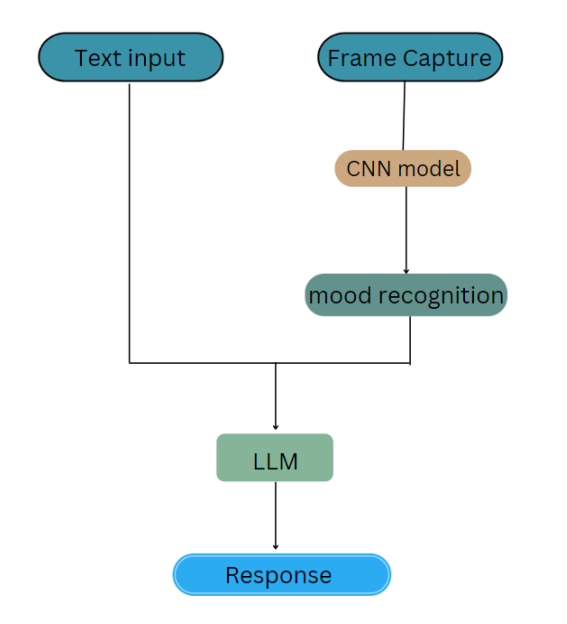

### Dataset
The AffectNet dataset, obtained from Kaggle, comprises over 1 million facial images labeled with seven emotions: anger, contempt, disgust, fear, happiness, sadness, and surprise, in addition to neutral expressions. Noteworthy for its diversity, the dataset encompasses images from the internet, showcasing variations in lighting, background, facial orientation, ethnicity, age, and gender. In this project, we concentrated on four primary emotions: anger, sadness, happiness, and fear, selected for their distinctive and easily recognizable facial characteristics, pivotal for practical applications. Each image in AffectNet is meticulously annotated by human annotators, ensuring the accuracy of labels. With images sized at 96x96 pixels, the dataset strikes a balance, facilitating detailed facial feature extraction without excessive computational demands.

 ### Data Preprocessing

### Converting the Dataset
The original dataset containing images of seven different emotions is filtered to include only four
emotions: anger, sad, happy, and fear. This reduction is aimed at improving the model’s accuracy.

In [ ]:
import os
import shutil
from os.path import join
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.utils import to_categorical


Firstly let's extract and organizes images based on specified emotions from a dataset. It defines the data directory, selects target emotions, creates a directory for selected images, and extracts emotion labels from file paths. This preprocessing step is crucial for preparing data for subsequent model training.

In [ ]:
# Define the directory containing the training data
data_dir = '/kaggle/input/affectnet-training-data'

# Load the CSV file containing the labels
csv_file = os.path.join(data_dir, 'labels.csv')
labels_df = pd.read_csv(csv_file)

# Emotions to use
selected_emotions = ['anger', 'sad', 'happy', 'fear']

# Directory to save selected images
selected_dir = 'selected_images_f'
os.makedirs(selected_dir, exist_ok=True)

def extract_label_from_path(file_path):
    # Split the file path into its components using '/' as the delimiter
    parts = file_path.split('/')

    # Check if the split results in at least two parts (i.e., there are at least two '/' in the path)
    if len(parts) >= 2:
        # The emotion label is assumed to be the second-to-last part of the path
        emotion_label = parts[-2]

        # Convert the extracted emotion label to lowercase
        return emotion_label.lower()
    else:
        # If the path does not have enough parts, return None
        return None


This code iterates through each file in the specified directory, filters images based on their extensions, extracts emotion labels from their relative paths, and copies selected images to destination directories corresponding to their emotions. It ensures that only images with valid and selected emotions are processed and copied while maintaining the folder structure. Finally, it prints a message confirming the completion of the selection and copying process.

In [ ]:
# Filter and process each image
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Check if the file is a .jpg or .png image
        if file.endswith('.jpg') or file.endswith('.png'):
            # Construct the full path to the source file
            src_path = os.path.join(root, file)

            # Extract the relative path from the data directory to the file
            rel_path = os.path.relpath(src_path, data_dir)

            # Extract the emotion label from the relative path
            emotion_label = extract_label_from_path(rel_path)

            # Check if the emotion label is valid and is in the selected emotions
            if emotion_label and emotion_label in selected_emotions:
                # Create the destination subdirectory for the emotion if it doesn't exist
                dest_subdir = os.path.join(selected_dir, emotion_label)
                os.makedirs(dest_subdir, exist_ok=True)

                # Construct the full path to the destination file
                dst_path = os.path.join(dest_subdir, file)

                # Copy the file from the source to the destination
                shutil.copy(src_path, dst_path)
            else:
                # Print a message if the file is ignored
                print(f"Ignoring: {src_path} (Invalid or non-selected emotion)")

print("Selected images for specified emotions have been copied to the 'selected_images_f' directory with preserved folder structure.")


#### Loading the Dataset
The filtered images are loaded into the program, and the number of images per emotion is counted
to ensure a balanced dataset. This step is crucial for ensuring that the model is trained on a well distributed dataset, preventing bias toward any particular emotion.


In [ ]:
# Define the input path where the images are stored
INPUT_PATH = "/kaggle/working/selected_images_f"

# Create a list of emotion labels by scanning the directories in the input path
# Each directory name corresponds to an emotion
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]

# Define the target image size for processing (width, height)
IMAGE_SIZE = (128, 128)

# Initialize a dictionary to hold the count of images for each emotion
emotion_image_counts = {}

# Loop through each emotion to count the number of images in each corresponding directory
for emotion in EMOTIONS:
    # Construct the path to the current emotion directory
    emotion_path = os.path.join(INPUT_PATH, emotion)
    # Count the number of image files in the emotion directory
    num_images = len([f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))])
    # Store the count in the dictionary with the emotion as the key
    emotion_image_counts[emotion] = num_images

# Loop through the dictionary to print out the number of images for each emotion
for emotion, count in emotion_image_counts.items():
    print(f"Emotion: {emotion}, Number of Images: {count}")


Emotion: anger, Number of Images: 3218
Emotion: sad, Number of Images: 3091
Emotion: fear, Number of Images: 3176
Emotion: happy, Number of Images: 5044


In [ ]:
EMOTIONS

['anger', 'sad', 'fear', 'happy']

#### Preprocessing Images
Images are standardized by resizing and normalizing them. This ensures that all images fed into the
model have consistent dimensions and pixel value distributions, which is critical for effective training.


This function serves as a generator to yield processed images and their corresponding emotion indices. It iterates over each emotion directory within the input path, reads images, converts them to RGB format, resizes them to the specified dimensions, and normalizes pixel values to the range [0, 1]. Finally, it yields the processed image along with its emotion index.

In [ ]:
def image_generator(input_path, emotions, image_size):
    # Loop over each emotion, along with its index
    for index, emotion in enumerate(emotions):
        # Loop over each file in the current emotion directory
        for filename in os.listdir(os.path.join(input_path, emotion)):
            # Read the image from the file
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            # Convert the image from BGR color space to RGB color space
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize the image to the specified dimensions
            img = cv2.resize(img, image_size)
            # Normalize the image pixels to the range [0, 1]
            img = img.astype('float32') / 255.0
            # Yield the processed image and its corresponding emotion index
            yield img, index


This function `load_images` utilizes the `image_generator` function to load and preprocess images along with their corresponding labels. It iterates over each image yielded by the generator, appends the processed image to a list `X`, and the corresponding label to another list `y`. After processing all images, it converts the lists into NumPy arrays. The labels are then converted to categorical format (one-hot encoding) using the `to_categorical` function from Keras. Finally, it returns the arrays of images (`X`) and labels (`y`).

In [ ]:
def load_images(input_path, emotions, image_size):
    # Initialize empty lists to store images (X) and labels (y)
    X, y = [], []

    # Use the image_generator to load and preprocess images along with their labels
    for img, label in image_generator(input_path, emotions, image_size):
        # Append the processed image to the X list
        X.append(img)
        # Append the corresponding label to the y list
        y.append(label)

    # Convert the list of images to a NumPy array
    X = np.array(X)
    # Convert the list of labels to a NumPy array and then to categorical format (one-hot encoding)
    y = to_categorical(np.array(y))

    # Return the arrays of images and labels
    return X, y

In [ ]:
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)

In [ ]:
#defining the shape of input
input_shape = X[0].shape

In [ ]:
#shape of the input
input_shape

(128, 128, 3)

Let's randomly selects an index from the available images dataset, then displays the image corresponding to that index using Matplotlib. It sets the title of the plot to the emotion label associated with the displayed image. The `np.argmax(y[idx])` expression retrieves the index of the highest value in the one-hot encoded label for that particular image. Finally, it removes the axis for a cleaner visual presentation before displaying the plot.

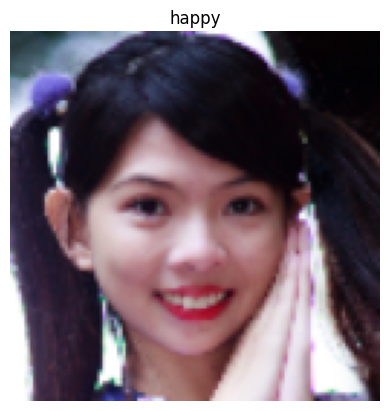

In [ ]:
# Select a random index from the range of available images
idx = np.random.randint(len(X))

# Display the image at the randomly selected index using matplotlib
plt.imshow(X[idx])

# Set the title of the plot to the emotion corresponding to the image
# np.argmax(y[idx]) is used to get the index of the highest value in the one-hot encoded label
plt.title(EMOTIONS[np.argmax(y[idx])])

# Remove the axis for a cleaner look
plt.axis('off')

# Display the plot
plt.show()


Now utilizes the `train_test_split` function from the `sklearn.model_selection` module to split the dataset into training and testing sets. It assigns the training data and labels to `X_train` and `y_train`, respectively, while the testing data and labels are assigned to `X_test` and `y_test`, respectively. The `test_size` parameter specifies that 20% of the data will be allocated for testing, while `random_state=123` ensures the reproducibility of the split.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# X_train and y_train will contain the training data and labels, respectively
# X_test and y_test will contain the testing data and labels, respectively
# test_size=0.2 specifies that 20% of the data will be used for testing
# random_state=123 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


#### Model-1 Architecture

Now for the next step let's defines a convolutional neural network (CNN) model using TensorFlow's Keras API for emotion classification. Here's a breakdown of the model architecture:

1. **Convolutional Layers**:
   - **Purpose**: These layers apply convolution operations to the input, extracting features like edges, textures, and shapes.
   - **Batch Normalization**: This helps in normalizing the inputs of each layer, which can accelerate training and provide some regularization to the model.
   - **SELU Activation**: The Scaled Exponential Linear Unit (SELU) activation function is used for its self-normalizing properties, which helps in maintaining a mean of zero and unit variance, potentially leading to faster convergence.

2. **Max Pooling Layers**:
   - **Purpose**: These layers downsample the feature maps, reducing the spatial dimensions and computational load, and making the model more robust to translations of the input image.

3. **Dropout Layers**:
   - **Purpose**: Dropout is a regularization technique used to prevent overfitting. By randomly dropping units during training, it helps in creating a more robust model that generalizes better to unseen data.

4. **Flatten Layer**:
   - **Purpose**: This layer converts the 2D feature maps into a 1D feature vector, which can be fed into fully connected (dense) layers.

5. **Dense Layers**:
   - **Purpose**: These layers perform high-level reasoning by combining the features extracted by the convolutional layers.
   - **L2 Regularization**: This technique penalizes large weights, encouraging the model to keep the weights small and thereby helping in reducing overfitting.
   - **Batch Normalization and Dropout**: Applied to further regularize the model and improve convergence.

6. **Output Layer**:
   - **Purpose**: The final dense layer with softmax activation outputs the probabilities for each emotion class, facilitating multi-class classification.

#### Compilation

- **Adam Optimizer**: An adaptive learning rate optimization algorithm that adjusts the learning rate throughout training, which can lead to faster convergence.
- **Learning Rate**: Set to 0.001, a common choice for many tasks.
- **Loss Function**: Categorical crossentropy is used as it is well-suited for multi-class classification problems.
- **Evaluation Metric**: Accuracy is used to monitor the performance of the model during training and evaluation.

#### Model Summary

The model summary provides an overview of the architecture, including the number of parameters in each layer. This helps in understanding the complexity of the model and in diagnosing potential issues related to overfitting or underfitting.

### Theoretical Concepts

1. **Convolutional Layers**:
   - **Filters/Kernels**: Small matrices that slide over the input data to extract features. The learned filters can detect various patterns such as edges, textures, and shapes.
   - **Stride and Padding**: Stride controls the step size of the filter while sliding. Padding allows the convolution operation to preserve the spatial dimensions of the input.

2. **Batch Normalization**:
   - **Normalization**: Helps in stabilizing and accelerating the training process by normalizing the inputs of each layer.
   - **Regularization**: Provides a slight regularization effect, helping in reducing overfitting.

3. **SELU Activation**:
   - **Self-Normalizing Networks**: SELU activation helps in maintaining the mean and variance of the activations close to zero and one, respectively, through a special initialization and activation function.

4. **Max Pooling**:
   - **Downsampling**: Reduces the spatial dimensions of the feature maps, thus decreasing the computational complexity and making the model invariant to small translations.
   - **Translation Invariance**: Helps the model learn more robust features that are less sensitive to the exact position of the features in the input image.

5. **Dropout**:
   - **Regularization**: Prevents overfitting by randomly setting a fraction of input units to zero during training, forcing the network to learn redundant representations.

6. **Dense Layers and L2 Regularization**:
   - **Fully Connected Layers**: These layers learn high-level abstractions from the features extracted by the convolutional layers.
   - **L2 Regularization**: Penalizes large weights in the network, encouraging the learning of simpler models that generalize better to unseen data.

7. **Softmax Activation**:
   - **Probability Distribution**: Converts the output logits into probabilities, making it suitable for multi-class classification tasks.

8. **Adam Optimizer**:
   - **Adaptive Learning Rates**: Adjusts the learning rate for each parameter individually, combining the advantages of two other extensions of stochastic gradient descent.

By combining these theoretical concepts with practical implementation details, this CNN model is designed to effectively capture and classify emotions from input facial images. The architecture leverages convolutional layers for feature extraction, pooling layers for downsampling, dropout for regularization, and dense layers for final classification, all compiled with efficient optimization and loss functions.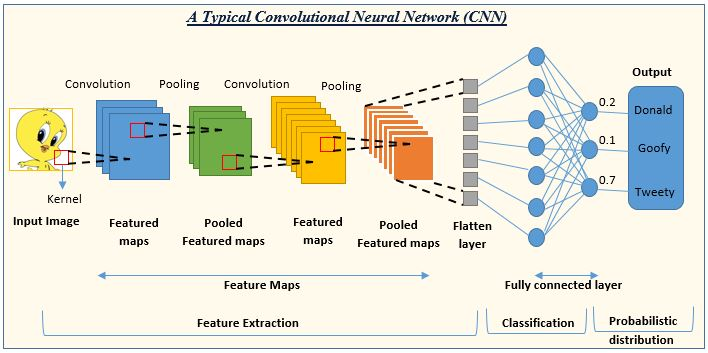

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Initialize a Sequential model
model = Sequential()

# Add the first convolutional layer with 32 filters, each with a 3x3 kernel, using the SELU activation function
# Specify the input shape to match the shape of the input images
model.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
# Add batch normalization layer to normalize the activations of the previous layer
model.add(BatchNormalization())
# Add max pooling layer with a 2x2 pool size
model.add(MaxPool2D(pool_size=(2,2)))
# Add dropout layer to prevent overfitting by randomly setting 25% of the input units to 0
model.add(Dropout(0.25))

# Add another set of convolutional layers with 64 filters each
model.add(Conv2D(64, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Add another set of convolutional layers with 128 filters each
model.add(Conv2D(128, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Add another set of convolutional layers with 256 filters each
model.add(Conv2D(256, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers to feed into the dense layers
model.add(Flatten())

# Add a dense layer with 128 units and SELU activation function
# Apply L2 regularization with a regularization parameter of 0.01
model.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
# Add dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer with 4 units and softmax activation function for multi-class classification
model.add(Dense(4, activation='softmax'))

# Compile the model using the Adam optimizer with a learning rate of 0.001
# Use categorical crossentropy as the loss function and accuracy as the metric
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model architecture
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,692,164 (6.46 MB)

 Trainable params: 1,690,052 (6.45 MB)

 Non-trainable params: 2,112 (8.25 KB)

#### Training and Evaluation

Now let's set up and train the CNN model using specific callbacks to improve training efficiency and performance:

1. **EarlyStopping**: This callback stops the training process if the validation loss does not improve for 10 consecutive epochs, preventing overfitting by ensuring the model does not train longer than necessary.

2. **ReduceLROnPlateau**: This callback dynamically reduces the learning rate when the validation loss stops improving. This helps fine-tune the model by adjusting the learning rate to smaller values when the model reaches a plateau, allowing for more precise weight updates.

3. **ModelCheckpoint**: This callback saves the model's weights to a file (`best_model.weights.h5`) whenever there is an improvement in validation accuracy. It saves only the weights and not the entire model, and it only saves the best model based on the validation accuracy.

#### Training Configuration
- **Data**: The model is trained using `X_train` (training data) and `y_train` (training labels), with `X_test` (testing data) and `y_test` (testing labels) used for validation.
- **Batch Size**: The model processes 64 samples at a time before updating the model parameters, which helps manage memory usage and speed up training.
- **Epochs**: The training runs for up to 25 epochs, allowing sufficient time for the model to learn patterns in the data.
- **Callbacks**: The defined callbacks are used during training to monitor performance and adjust parameters, enhancing the model's efficiency and effectiveness.

This approach ensures that the model training is optimized, prevents overfitting, and saves the best-performing model weights, resulting in a robust and well-trained emotion detection model.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the filepath with .weights.h5 extension
checkpoint_filepath = 'best_model.weights.h5'

# Configure callbacks with corrected filepath
callbacks = [
    # EarlyStopping: Stop training when a monitored metric has stopped improving
    EarlyStopping(patience=10, monitor='val_loss', mode='min'),

    # ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(patience=2, verbose=1),

    # ModelCheckpoint: Save the model's weights during training
    ModelCheckpoint(
        checkpoint_filepath,  # Filepath to save the best model weights
        save_best_only=True,  # Save only the best model
        save_weights_only=True,  # Save only the weights, not the entire model
        monitor='val_accuracy',  # Monitor validation accuracy for saving
        mode='max'  # Save when the monitored metric is at its maximum
    )
]

# Example usage in model.fit()
history = model.fit(
    X_train,  # Training data
    y_train,  # Training labels
    batch_size=64,  # Number of samples per gradient update
    epochs=25,  # Number of epochs to train the model
    validation_data=(X_test, y_test),  # Validation data
    callbacks=callbacks,  # Callbacks for monitoring and saving
    verbose=1  # Verbosity mode (1: progress bar, 0: silent)
)


Epoch 1/25
  2/182 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.2422 - loss: 5.2752 

W0000 00:00:1715862547.312117     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5685 - loss: 3.3728

W0000 00:00:1715862570.044935     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715862571.894462     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.5688 - loss: 3.3691 - val_accuracy: 0.6820 - val_loss: 1.6105 - learning_rate: 0.0010
Epoch 2/25


W0000 00:00:1715862573.683746     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.6856 - loss: 1.3736 - val_accuracy: 0.6834 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.7334 - loss: 0.8413 - val_accuracy: 0.7330 - val_loss: 0.7791 - learning_rate: 0.0010
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7475 - loss: 0.7640 - val_accuracy: 0.6132 - val_loss: 1.3631 - learning_rate: 0.0010
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7626 - loss: 0.7378 - val_accuracy: 0.7643 - val_loss: 0.7427 - learning_rate: 0.0010
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7750 - loss: 0.7186 - val_accuracy: 0.7099 - val_loss: 0.8419 - learning_rate: 0.0010
Epoch 7/25
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7855 - loss: 0.6831
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7855 - loss: 0.6833 

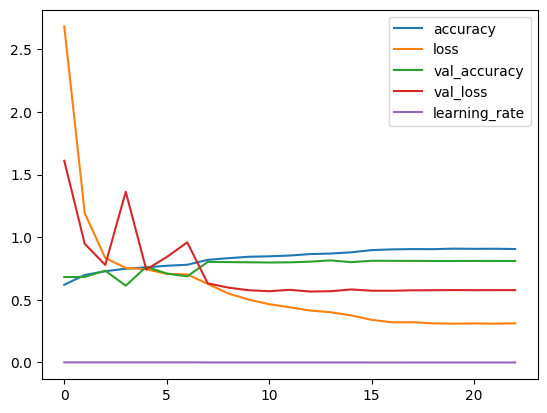

In [ ]:
#plotting the loss and accuracy curve
pd.DataFrame(history.history).plot();

Now we will evaluate the performance of the trained CNN model. By  converting  the one-hot encoded test labels back to integer labels, uses the model to predict labels for the test data, converts these predictions to integer labels, and then computes and prints a classification report.

The classification report includes the following metrics:

- **Precision**: The ratio of true positive predictions to the total predicted positives (i.e., the number of correct positive predictions divided by the total number of positive predictions). It indicates how many of the predicted positive instances are actually positive.
- **Recall (Sensitivity)**: The ratio of true positive predictions to the total actual positives (i.e., the number of correct positive predictions divided by the total number of actual positive instances). It measures the ability of the model to identify all relevant instances.
- **F1-Score**: The harmonic mean of precision and recall, providing a single metric that balances both concerns. It is useful when you need to account for both false positives and false negatives.
- **Support**: The number of actual occurrences of each class in the test data. It indicates how many instances there are in each class.

This comprehensive evaluation of the model's accuracy helps in understanding how well the model is performing across different classes, highlighting any strengths and weaknesses.

In [ ]:
# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to integer labels for y_test
y_test_int = np.argmax(y_test, axis=1)

# Use the trained model to make predictions on the testing data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to integer labels
y_pred_int = np.argmax(y_pred, axis=1)

# Compute and print the classification report
# The classification report contains precision, recall, F1-score, and support for each class
print(classification_report(y_test_int, y_pred_int))

13/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

W0000 00:00:1715862906.862642     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       641
           1       0.69      0.65      0.67       618
           2       0.76      0.74      0.75       644
           3       1.00      0.99      0.99      1003

    accuracy                           0.81      2906
   macro avg       0.78      0.78      0.78      2906
weighted avg       0.81      0.81      0.81      2906



W0000 00:00:1715862908.638401     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Now for more clear view of evalutation we will predict random images from the test set by defining a function to visualize the model's predictions on random test images. It selects random indices from the test set, retrieves the corresponding images and labels, and uses the model to predict the labels. The images are then displayed with both the predicted and original labels. The function plots four images by default, showcasing the model's performance visually.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


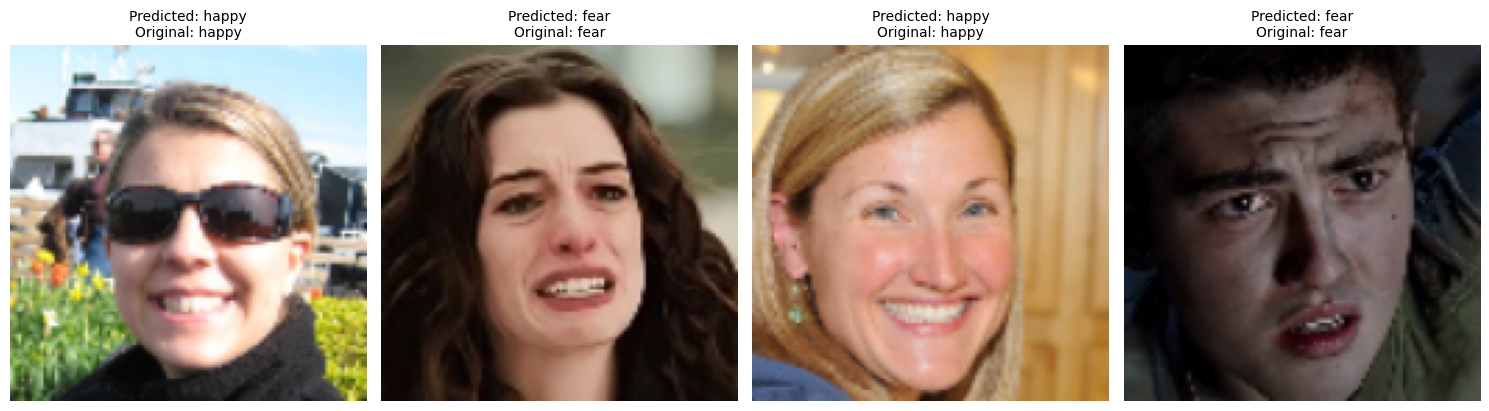

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['anger', 'sad', 'fear', 'happy']

# Function to predict and plot random test images with predicted and original labels
def predict_and_plot_test_images(model, x_test, y_test, class_labels, num_images=4):
    # Randomly select indices for test images
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)

    # Create subplots for displaying the images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    # Loop over randomly selected indices
    for i, idx in enumerate(random_indices):
        # Get the test image and its true label
        test_image = x_test[idx]
        true_label = class_labels[np.argmax(y_test[idx])]

        # Expand dimensions to make it compatible with the model input shape
        test_image = np.expand_dims(test_image, axis=0)

        # Predict the label using the model
        prediction = model.predict(test_image)
        predicted_label = class_labels[np.argmax(prediction)]

        # Plot the image along with predicted and original labels
        axs[i].imshow(test_image.squeeze())
        axs[i].set_title(f'Predicted: {predicted_label}\nOriginal: {true_label}', fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to predict and plot test images
predict_and_plot_test_images(model, X_test, y_test, class_labels, num_images=4)

#### Model-2 Architecture

Now, let's define another Convolutional Neural Network (CNN) model using TensorFlow's Keras API for a better emotion classification than the previous one. Here's an overview of the model architecture:

- **Convolutional Layers**: The model begins with several convolutional layers, each followed by batch normalization and SELU activation. These layers extract increasingly complex features, with the number of filters growing from 32 to 256.

- **Max Pooling Layers**: After each pair of convolutional layers, max-pooling layers downsample the feature maps, maintaining the most essential information.

- **Dropout**: Dropout layers with a dropout rate of 25% are inserted after each max-pooling layer to mitigate overfitting.

- **Flatten**: The output from the convolutional layers is flattened to prepare for input into the dense layers.

- **Dense Layers**: Two dense layers with SELU activation are included. The first dense layer has 128 units and applies L2 regularization with a regularization parameter of 0.01. Before the output layer, batch normalization and dropout with a rate of 50% are applied.

- **Output Layer**: The output layer consists of four units, one for each emotion class, with softmax activation for multi-class classification.

- **Compilation**: The model is compiled using the Adam optimizer with a learning rate of 0.001. Categorical cross-entropy serves as the loss function, and accuracy is the evaluation metric.

- **Summary**: Finally, the model architecture's summary, detailing layer sizes and parameter counts, is printed to provide insight into the model's structure.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Initialize a Sequential model
model_3 = Sequential()

# Add convolutional layers with 32 filters, each with a 3x3 kernel, and SELU activation function
model_3.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))  # Max pooling layer
model_3.add(Dropout(0.25))  # Dropout layer to prevent overfitting

# Add more convolutional layers with 64 filters each
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

# Add more convolutional layers with 128 filters each
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

# Add more convolutional layers with 256 filters each
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

# Flatten the output from the convolutional layers to feed into the dense layers
model_3.add(Flatten())

# Add a dense layer with 128 units and SELU activation function
# Apply L2 regularization with a regularization parameter of 0.01
model_3.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Add the output layer with 4 units and softmax activation function for multi-class classification
model_3.add(Dense(4, activation='softmax'))

# Compile the model using the Adam optimizer with a learning rate of 0.001
# Use categorical crossentropy as the loss function and accuracy as the metric
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model architecture
model_3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,692,164 (6.46 MB)

 Trainable params: 1,690,052 (6.45 MB)

 Non-trainable params: 2,112 (8.25 KB)

#### Training and Evaluation

All the steps redarding the traing and evaluation are same as for the above model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the filepath with .weights.h5 extension
checkpoint_filepath = 'best_model.weights.h5'

# Configure callbacks with corrected filepath
callbacks = [
    # EarlyStopping: Stop training when a monitored metric has stopped improving
    EarlyStopping(patience=10, monitor='val_loss', mode='min'),

    # ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(patience=2, verbose=1),

    # ModelCheckpoint: Save the model's weights during training
    ModelCheckpoint(
        checkpoint_filepath,  # Filepath to save the best model weights
        save_best_only=True,  # Save only the best model
        save_weights_only=True,  # Save only the weights, not the entire model
        monitor='val_accuracy',  # Monitor validation accuracy for saving
        mode='max'  # Save when the monitored metric is at its maximum
    )
]

# Example usage in model.fit()
history = model_3.fit(
    X_train,  # Training data
    y_train,  # Training labels
    batch_size=64,  # Number of samples per gradient update
    epochs=25,  # Number of epochs to train the model
    validation_data=(X_test, y_test),  # Validation data
    callbacks=callbacks,  # Callbacks for monitoring and saving
    verbose=1  # Verbosity mode (1: progress bar, 0: silent)
)


Epoch 1/25
  2/182 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.2383 - loss: 5.2146   

I0000 00:00:1715862145.270254     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715862145.297579     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5707 - loss: 3.3631

W0000 00:00:1715862172.542863     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715862174.856798     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 58s 182ms/step - accuracy: 0.5709 - loss: 3.3593 - val_accuracy: 0.6497 - val_loss: 1.6157 - learning_rate: 0.0010
Epoch 2/25


W0000 00:00:1715862178.234137     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.6908 - loss: 1.3459 - val_accuracy: 0.6872 - val_loss: 0.9173 - learning_rate: 0.0010
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7238 - loss: 0.8514 - val_accuracy: 0.7316 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7433 - loss: 0.7604 - val_accuracy: 0.6022 - val_loss: 1.2905 - learning_rate: 0.0010
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7571 - loss: 0.7330 - val_accuracy: 0.7536 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7706 - loss: 0.7044 - val_accuracy: 0.7130 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 7/25
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7871 - loss: 0.6899
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.7870 - loss: 0.6901 

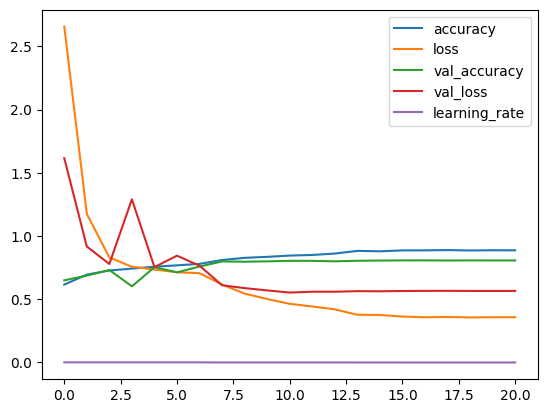

In [ ]:
#plotting the loss and accuracy curves
pd.DataFrame(history.history).plot();

In [ ]:
# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to integer labels for y_test
y_test_int = np.argmax(y_test, axis=1)

# Use the trained model to make predictions on the testing data
y_pred = model_3.predict(X_test)

# Convert the predicted probabilities to integer labels
y_pred_int = np.argmax(y_pred, axis=1)

# Compute and print the classification report
# The classification report contains precision, recall, F1-score, and support for each class
print(classification_report(y_test_int, y_pred_int))

19/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

W0000 00:00:1715862513.129754     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       641
           1       0.68      0.64      0.66       618
           2       0.77      0.72      0.74       644
           3       1.00      0.99      0.99      1003

    accuracy                           0.81      2906
   macro avg       0.78      0.78      0.78      2906
weighted avg       0.81      0.81      0.81      2906



W0000 00:00:1715862514.852452     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#### Predicting random images from the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


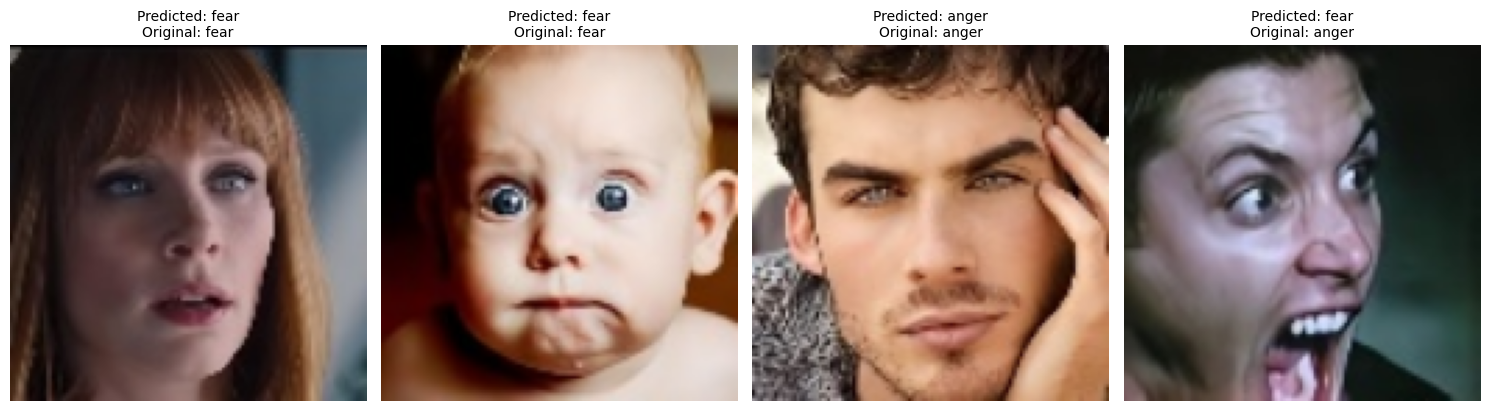

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['anger', 'sad', 'fear', 'happy']

# Function to predict and plot random test images with predicted and original labels
def predict_and_plot_test_images(model, x_test, y_test, class_labels, num_images=4):
    # Randomly select indices for test images
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)

    # Create subplots for displaying the images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    # Loop over randomly selected indices
    for i, idx in enumerate(random_indices):
        # Get the test image and its true label
        test_image = x_test[idx]
        true_label = class_labels[np.argmax(y_test[idx])]

        # Expand dimensions to make it compatible with the model input shape
        test_image = np.expand_dims(test_image, axis=0)

        # Predict the label using the model
        prediction = model_3.predict(test_image)
        predicted_label = class_labels[np.argmax(prediction)]

        # Plot the image along with predicted and original labels
        axs[i].imshow(test_image.squeeze())
        axs[i].set_title(f'Predicted: {predicted_label}\nOriginal: {true_label}', fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to predict and plot test images
predict_and_plot_test_images(model, X_test, y_test, class_labels, num_images=4)

##### Saving the best model

In [ ]:
model_3.save('model_f.h5')

#### LLM Integration

#### Large Language Models (LLMs)
LLMs, such as Google Gemini-Pro, are advanced machine learning models designed to understand and generate human-like text. They are based on transformer architectures, which allow them to handle large-scale language understanding and generation tasks.

Key Concepts:
Transformer Architecture: Introduced in the paper "Attention is All You Need" by Vaswani et al., the transformer model uses self-attention mechanisms to process input data in parallel, making it more efficient than previous recurrent architectures.
Self-Attention: This mechanism allows the model to weigh the importance of different words in a sentence when making predictions, capturing dependencies regardless of distance.
Pretraining and Fine-Tuning: LLMs are first pretrained on large corpora to learn general language patterns and then fine-tuned on specific tasks or datasets to specialize in particular domains or applications.
Generative Pretrained Transformer (GPT): A specific implementation of the transformer model used for generating coherent and contextually relevant text based on given prompts.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from dotenv import load_dotenv
import google.generativeai as gen_ai

#### Loading the API Key
The API key for the Google Gemini-Pro AI model is loaded from environment variables, allowing
the program to authenticate and use the model for generating empathetic responses.


In [ ]:
# Load environment variables
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Set up Google Gemini-Pro AI model
gen_ai.configure(api_key=GOOGLE_API_KEY)
model = gen_ai.GenerativeModel('gemini-pro')

#### Defining Functions
Utility functions are created to handle tasks such as capturing images from a webcam, preprocessing
these images, loading the emotion detection model, predicting emotions, and generating responses
using the Gemini-Pro model. These functions streamline the process of integrating emotion detection
with the chatbot’s conversational capabilities


Now let's define functions for emotion detection using a pre-trained model and processing webcam frames:

- **Load Emotion Detection Model**: This function loads a pre-trained emotion detection model from the specified path using TensorFlow's Keras API.

- **Preprocess Frame for Emotion Detection**: Given a frame captured from the webcam, this function preprocesses it by converting the color space to RGB, resizing it to the specified image size, and normalizing the pixel values to the range [0, 1].

- **Predict Emotion from Webcam Frame**: Using the loaded model and a preprocessed frame, this function predicts the dominant emotion present in the frame by obtaining predictions from the model and selecting the emotion with the highest probability.

- **Capture Frame from Webcam**: This function captures a single frame from the webcam using OpenCV. It initializes the webcam, captures a frame, and then releases the webcam resources.

These functions work together to capture frames from the webcam, preprocess them, and predict the dominant emotion present in each frame using the pre-trained emotion detection model.

In [ ]:
# Load Emotion Detection Model
def load_emotion_model(model_path):
    return tf.keras.models.load_model(model_path)

# Preprocess Frame for Emotion Detection
def preprocess_frame(frame, image_size):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=0)

# Predict Emotion from Webcam Frame
def predict_emotion(model, frame, image_size):
    preprocessed_frame = preprocess_frame(frame, image_size)
    predictions = model.predict(preprocessed_frame)
    emotion = np.argmax(predictions)
    return emotion

# Capture Frame from Webcam
def capture_frame():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cap.release()
    return frame

Now let's loads the pre-trained emotion detection model from the file "model_f.h5" using the `load_emotion_model` function. And then creates an emotion dictionary where each emotion class index is mapped to its corresponding label. The emotions considered are happiness, sadness, anger, and fear, represented by the indices 0 to 3, respectively.

In [ ]:
# Load emotion detection model
emotion_model_path = "model_f.h5"
emotion_model = load_emotion_model(emotion_model_path)

# Emotion dictionary
emotion_dict = {0: 'happiness', 1: 'sadness', 2: 'anger', 3: 'fear'}

Next we define `get_gemini_response` function which is designed to generate a response from the Gemini-Pro AI model based on a given prompt and user question. The function takes two parameters: `question`, which represents the user's input text or question, and `prompt`, which provides context or instructions for generating the response.

And the `base_prompt` variable defines a template or base prompt for interacting with the Gemini-Pro model. It outlines the role and behavior of the empathetic assistant, specifying how it should respond based on the user's detected emotion (happy, sad, fear, or anger) and input text. The prompt emphasizes creating a positive and supportive environment, aiming to help users feel understood and valued. This base prompt serves as a guide for generating appropriate responses tailored to different emotional states.

Let's talk little about the Google Gemini-Pro:

Google Gemini-Pro is an advanced AI platform that merges sophisticated language models with powerful computational capabilities, offering robust solutions for diverse applications.

#### Key Features

1. **Advanced Language Understanding**:
   - Excels in NLP tasks such as text generation, translation, and sentiment analysis.
   - Maintains context over long conversations for coherent, relevant responses.

2. **High-Performance Computing**:
   - Scalable for large datasets and enterprise applications.
   - Provides high-speed processing and low-latency responses.

3. **Multimodal Capabilities**:
   - Integrates text and visual data for tasks like image captioning and visual question answering.
   - Seamlessly switches between text and visual processing inputs.

4. **Robust Security and Privacy**:
   - Employs advanced encryption and anonymization to protect user data.
   - Complies with global data protection regulations.

5. **Customization and Flexibility**:
   - Offers API and SDK access for easy integration and custom application development.
   - Allows fine-tuning on specific datasets for optimized performance.

6. **Continuous Learning and Improvement**:
   - Utilizes self-learning algorithms for ongoing performance enhancement.
   - Receives regular updates to stay at the forefront of AI technology.


In [ ]:
# Get Gemini response based on prompt
def get_gemini_response(question, prompt):
    response = model.generate_content([prompt, question])
    return response.text

# Define the base prompt for Gemini-Pro
base_prompt = """
You are an empathetic assistant dedicated to improving the user's mood based on their given detected emotion: happy, sad, fear, or anger
and input text. Your responses should be friendly and mood-appropriate:
Happy: Celebrate their joy and ask about the reason for their happiness. Provide enthusiastic reinforcement.
Sad: Offer comfort and empathy. Ask if they want to share what's making them sad and offer help.
Fear: Reassure them and acknowledge their fear. Offer practical advice to alleviate their fear.
Anger: Stay calm and listen. Validate their feelings and suggest ways to manage anger.
Your goal is to create a positive and supportive environment, helping users feel understood and valued.
"""

####  Chatbot Loop
The chatbot continuously interacts with the user by capturing webcam images to detect their emotions and generating appropriate responses. This loop ensures real-time interaction, making the
chatbot capable of responding empathetically based on the user’s detected emotional state.
This code effectively combines image processing, neural network training, and language model
integration to create a robust system capable of detecting emotions and providing empathetic responses in real-time, showcasing an advanced application of artificial intelligence in human-computer
interaction.

The `chatbot_loop` function serves as the main loop for the chatbot, allowing it to interact with users in a continuous manner. Here's how it works:

1. **Initialization**: The function starts by printing a message indicating that the chatbot is ready and prompts the user to type 'quit' to exit the session.

2. **User Input**: Within the loop, the chatbot waits for user input via the `input` function. The user's message is then stripped of leading and trailing whitespace.

3. **Handling Exit**: If the user inputs 'quit', the chatbot prints a message indicating that the session has ended and breaks out of the loop, terminating the program.

4. **Empty Input Check**: If the user enters an empty message, the chatbot prompts them to enter a valid message and continues waiting for input.

5. **Emotion Detection**: The chatbot captures a frame from the webcam using the `capture_frame` function and predicts the user's emotion using the loaded emotion detection model (`emotion_model`). The predicted emotion is then mapped to a corresponding label using the `emotion_dict` dictionary.

6. **Prompt Preparation**: A prompt is constructed based on the `base_prompt`, which provides context for the Gemini-Pro AI model. The prompt includes instructions for the empathetic assistant to respond based on the detected emotion and the user's input message.

7. **Gemini-Pro Response**: The user's message and the prepared prompt are passed to the `get_gemini_response` function, which generates a response from the Gemini-Pro model based on the provided input.

8. **Display Messages**: The chatbot prints the user's input message (`You: ...`) and the generated response from Gemini-Pro (`Bot: ...`) to the console.

9. **Loop Continuation**: The loop continues indefinitely, allowing the chatbot to respond to multiple user inputs until the user chooses to quit the session.

By following this loop, the chatbot can engage in personalized conversations with users, providing empathetic responses based on their detected emotions and input messages.

In [ ]:
# Main loop for the chatbot
def chatbot_loop():
    print("Chatbot is ready. Type 'quit' to exit.")
    while True:
        # Get user input
        user_message = input("You: ").strip()

        if user_message.lower() == "quit":
            print("Chatbot session ended.")
            break

        if user_message == "":
            print("Please enter a message.")
            continue

        # Capture frame from webcam
        frame = capture_frame()

        # Predict emotion
        emotion = predict_emotion(emotion_model, frame, image_size=(128, 128))
        detected_emotion = emotion_dict.get(emotion, 'neutral')

        # Prepare the prompt
        prompt = f"{base_prompt} The user is currently feeling {detected_emotion} and their input message is {user_message}."

        # Send user's message to Gemini-Pro and get the response
        gemini_response = get_gemini_response(user_message, prompt)

        # Display messages
        print(f"You: {user_message}")
        print(f"Bot: {gemini_response}")

# Start the chatbot loop
chatbot_loop()


#### Frontend Development

The `app.py` Streamlit application replicates the functionalities of the final notebook, integrating an emotion detection model with a language model to create an empathetic chatbot. It captures real-time webcam frames, predicts emotions, and generates appropriate responses using the Gemini-Pro AI model. Session state management in Streamlit maintains conversation history and context. User interactions are handled through a form with input validation. Responses are dynamically generated based on detected emotions and input messages. Custom CSS styling ensures a visually appealing chat interface. Overall, the application offers a seamless and engaging user experience with real-time interaction.

This `app.py` Streamlit application integrates an emotion detection model with the Google Gemini-Pro AI model to create an empathetic chatbot. Here's an overview of the code:

1. **Streamlit Configuration**: The page title, icon, and layout are configured using Streamlit's `st.set_page_config()` function.

2. **Google Gemini-Pro Configuration**: The Google API key is loaded from environment variables, and the Gemini-Pro AI model is configured using the `google.generativeai` library.

3. **Emotion Detection Model**: A function `load_emotion_model()` is defined to load the emotion detection model stored in an `.h5` file. The model is loaded using TensorFlow's Keras API.

4. **Preprocessing and Prediction**: Functions `preprocess_frame()` and `predict_emotion()` preprocess webcam frames and predict emotions using the loaded emotion detection model.

5. **Chat Session Initialization**: If a chat session is not already present in the Streamlit session state, it is initialized using the Gemini-Pro AI model's `start_chat()` method.

6. **CSS Styling**: CSS styles for different types of chat messages (user, bot, system) are defined to enhance the visual appearance of the chat interface.

7. **Chat History Management**: The application maintains a conversation history in the Streamlit session state. Messages are added to this history using the `add_message()` function.

8. **Display Messages**: The conversation history is displayed using Streamlit's `markdown()` function with HTML elements to apply the defined CSS styles.

9. **User Input Form**: A Streamlit form is used to capture user input. The form includes a text input field for users to enter their messages.

10. **User Interaction Handling**: When the form is submitted, the user's message is processed. If the message is empty or "quit", appropriate warnings or actions are triggered. Otherwise, the message is added to the chat history, and emotion detection and Gemini-Pro response generation are performed.

11. **Gemini-Pro Response Generation**: The user's message and detected emotion are used to construct a prompt for Gemini-Pro. The Gemini-Pro AI model generates a response based on this prompt, which is added to the chat history.

12. **Display Updated Chat History**: After processing the user's message and generating a bot response, the updated chat history is displayed to the user.

In [ ]:
#app.py

import os
import cv2
import numpy as np
import streamlit as st
from dotenv import load_dotenv
import tensorflow as tf
import google.generativeai as gen_ai

# Load environment variables
load_dotenv()

# Configure Streamlit page settings
st.set_page_config(
    page_title="Emotion-aware Chatbot",
    page_icon=":brain:",  # Favicon emoji
    layout="centered",  # Page layout option
)

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Set up Google Gemini-Pro AI model
gen_ai.configure(api_key=GOOGLE_API_KEY)
model = gen_ai.GenerativeModel('gemini-pro')

# Load Emotion Detection Model
def load_emotion_model(model_path):
    return tf.keras.models.load_model(model_path)

# Preprocess Frame for Emotion Detection
def preprocess_frame(frame, image_size):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=0)

# Predict Emotion from Webcam Frame
def predict_emotion(model, frame, image_size):
    preprocessed_frame = preprocess_frame(frame, image_size)
    predictions = model.predict(preprocessed_frame)
    emotion = np.argmax(predictions)  # Assuming your model returns a probability distribution
    return emotion

# Initialize chat session in Streamlit if not already present
if "chat_session" not in st.session_state:
    st.session_state.chat_session = model.start_chat(history=[])

# Define CSS styles for chat messages
st.markdown("""
<style>
    .message-container {
        max-height: 400px;
        overflow-y: auto;
        display: flex;
        flex-direction: column;
        margin-bottom: 10px;
    }
    .user-message {
        align-self: flex-end;
        background-color: #DCF8C6;
        border-radius: 10px;
        padding: 8px 12px;
        margin-bottom: 5px;
        max-width: 70%;
        text-align: left;
    }
    .ai-message {
        align-self: flex-start;
        background-color: #E0E0E0;
        border-radius: 10px;
        padding: 8px 12px;
        margin-bottom: 5px;
        max-width: 70%;
        text-align: left;
    }
    .system-message {
        align-self: center;
        background-color: #F5F5F5;
        border-radius: 10px;
        padding: 8px 12px;
        margin-bottom: 5px;
        max-width: 70%;
        text-align: center;
    }
</style>
""", unsafe_allow_html=True)

# Initialize conversation history
if 'flowmessages' not in st.session_state:
    st.session_state['flowmessages'] = [
        {"role": "system", "content": "Welcome! I'm here to chat with you."}
    ]

# Function to add messages to chat history
def add_message(role, content):
    st.session_state['flowmessages'].append({"role": role, "content": content})

# Display messages
def display_messages():
    st.markdown('<div class="message-container">', unsafe_allow_html=True)
    for message in st.session_state['flowmessages']:
        if message['role'] == 'system':
            st.markdown(f'<div class="system-message">{message["content"]}</div>', unsafe_allow_html=True)
        elif message['role'] == 'user':
            st.markdown(f'<div class="user-message">{message["content"]}</div>', unsafe_allow_html=True)
        elif message['role'] == 'bot':
            st.markdown(f'<div class="ai-message">{message["content"]}</div>', unsafe_allow_html=True)
    st.markdown('</div>', unsafe_allow_html=True)

# Display previous chat history
display_messages()

# Capture Frame from Webcam
def capture_frame():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cap.release()
    return frame

# Load emotion detection model
emotion_model_path = "model_f.h5"
emotion_model = load_emotion_model(emotion_model_path)

# Emotion dictionary
emotion_dict = {0: 'happiness', 1: 'sadness', 2: 'anger', 3: 'fear'}

# Get Gemini response based on prompt
def get_gemini_response(question, prompt):
    response = model.generate_content([prompt, question])
    return response.text

# Define the base prompt for Gemini-Pro
base_prompt = """
You are an empathetic assistant dedicated to improving the user's mood based on their given detected emotion: happy, sad, fear, or anger
and input text. Your responses should be friendly and mood-appropriate:
Happy: Celebrate their joy and ask about the reason for their happiness. Provide enthusiastic reinforcement.
Sad: Offer comfort and empathy. Ask if they want to share what's making them sad and offer help.
Fear: Reassure them and acknowledge their fear. Offer practical advice to alleviate their fear.
Anger: Stay calm and listen. Validate their feelings and suggest ways to manage anger.
Your goal is to create a positive and supportive environment, helping users feel understood and valued.
"""

# Get user input
with st.form(key="user_input_form", clear_on_submit=True):
    user_input = st.text_input("You: ", key="input")
    submit_button = st.form_submit_button(label="Submit")

if submit_button:
    if user_input.strip() == "":
        st.warning("Please enter a message.")
    elif user_input.lower().strip() == "quit":
        st.stop()
    else:
        # Add user message to chat history
        add_message('user', user_input)

        # Capture frame from webcam
        frame = capture_frame()

        # Predict emotion
        emotion = predict_emotion(emotion_model, frame, image_size=(128, 128))
        detected_emotion = emotion_dict.get(emotion, 'neutral')

        # Prepare the prompt
        prompt = f"{base_prompt} The user is currently feeling {detected_emotion} and his input message is {user_input}."
        # Send user's message to Gemini-Pro and get the response
        gemini_response = get_gemini_response(user_input, prompt)

        # Add bot response to chat history
        add_message('bot', gemini_response)

        # Display updated chat history
        display_messages()

#### Results

Previous attempts:
Previous attempts involved using eight emotions for mood detection using a pre-trained model and
two custom-defined models. The results showed classification reports and plots, indicating the model’s
performance. However, accuracies and other metrics were observed to be very low. The complexity
of distinguishing between eight emotions might have contributed to this, as the models struggled to
generalize across a broad range of emotional states.




### Pre-trained Models

#### VGG16
1. **Architecture**: VGG16 is a deep convolutional neural network architecture introduced by the Visual Geometry Group from the University of Oxford. It consists of 16 layers (13 convolutional layers, 3 fully connected layers) and is known for its simplicity and effectiveness in image classification tasks. It uses small 3x3 convolution filters and a uniform architecture with deep layers, which enhances its ability to capture detailed features.
2. **Accuracy**: 60.40%

#### MobileNetV2
1. **Architecture**: MobileNetV2 is a lightweight deep neural network architecture developed by Google. It is designed for mobile and embedded vision applications. It improves upon the original MobileNet by introducing inverted residuals and linear bottlenecks, which enhance performance while maintaining computational efficiency. This architecture balances high accuracy with low resource consumption.
2. **Accuracy**: 47.59%

#### Custom Convolutional Neural Networks (CNNs)

##### Model C1
This custom CNN model is built with a series of convolutional, batch normalization, max pooling, dropout, and dense layers to extract features and perform classification.

| Layers Used             | Number |
|-------------------------|--------|
| Convolutional layers    | 6      |
| Batch normalization layers | 2      |
| Max pooling layers      | 3      |
| Dropout layers          | 3      |
| Dense layers            | 2      |
| Flatten layer           | 1      |

**Accuracy Achieved**: 60.07%

##### Model C2
This custom CNN incorporates a deeper architecture with more layers, including batch normalization and dropout layers, to improve regularization and prevent overfitting.

| Layers Used             | Number |
|-------------------------|--------|
| Convolutional layers    | 8      |
| Batch normalization layers | 6      |
| Max pooling layers      | 4      |
| Dropout layers          | 4      |
| Dense layers            | 2      |
| Flatten layer           | 1      |

**Accuracy Achieved**: 69.25%

##### Model C3
This custom CNN model is very similar to Model C2, but slight adjustments in the architecture or hyperparameters result in a marginally higher accuracy.

| Layers Used             | Number |
|-------------------------|--------|
| Convolutional layers    | 8      |
| Batch normalization layers | 6      |
| Max pooling layers      | 4      |
| Dropout layers          | 4      |
| Dense layers            | 2      |
| Flatten layer           | 1      |

**Accuracy Achieved**: 69.41%

#### Challenges in Emotion Classification
Distinguishing between similar emotional states, such as anger and disgust, poses a significant challenge for mood detection models. These emotions often share overlapping facial expressions and features, making it difficult for models to generalize well across such nuanced differences. The complexity of the task is reflected in the varied performance of the models, with custom CNNs (C2 and C3) demonstrating higher accuracy due to their deeper architectures and sophisticated regularization techniques.
###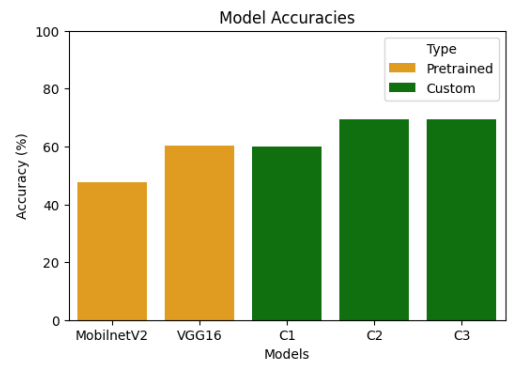


### Improved Approach

To address the low accuracy, we reduced the number of emotions to four: anger, sad, happy, and fear. These emotions were chosen because they can be distinguished easily, allowing the models to be trained more effectively. Anger, sadness, happiness, and fear are fundamental emotions with distinct characteristics that can be recognized through facial expressions and other physiological cues, making them suitable for effective emotion detection.

#### Comparison and Outcome
The simplified model focusing on four emotions significantly improved accuracy and other metrics compared to the previous attempts. Specifically, the reduced emotional range allowed the models to focus more effectively on distinguishing between the four primary emotional states. This approach led to a clearer differentiation between emotions and improved model performance.

##### These are accuacies of diferent models:
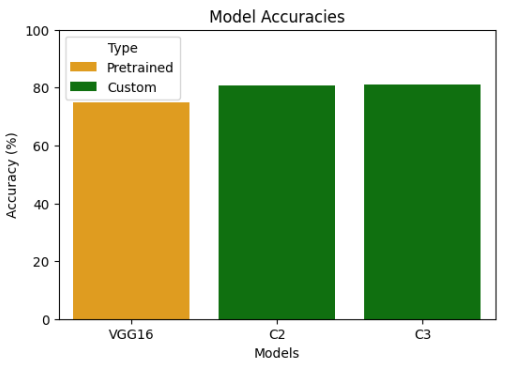



##### So C3 model is choosen as the final model and metrics of the choosen model are as follows:
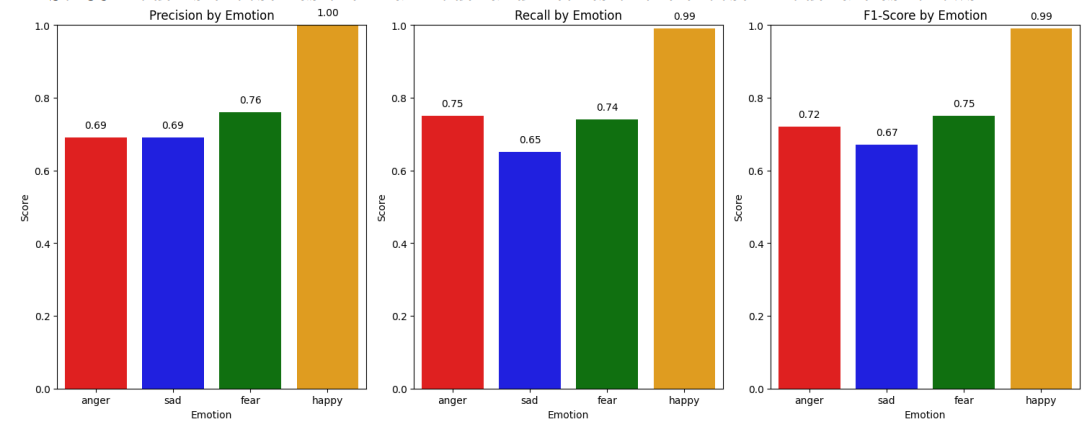

### Conclusion

In conclusion, the development of KokoroBot represents a significant advancement in the field of human-computer interaction, leveraging AI to create empathetic and supportive chatbot interactions based on real-time emotional analysis. Key highlights and findings from the project include:

1. **Emotional Recognition and Response**: KokoroBot integrates a Convolutional Neural Network (CNN) for real-time emotion detection from webcam frames. This model effectively identifies user emotions such as happiness, sadness, anger, and fear, enabling the chatbot to respond empathetically and appropriately.

2. **Model Selection and Performance**: The project explored several pre-trained and custom CNN models for emotion classification. Ultimately, Model C3, a custom CNN architecture, was selected due to its superior accuracy and performance in distinguishing between the chosen emotional states.

3. **Integration of Technologies**: The chatbot was built using Streamlit for the frontend, providing a user-friendly interface for interaction. It integrates Google’s Gemini-Pro AI model for generating empathetic responses, enhancing the quality of user-bot interactions.

4. **Dataset and Data Preprocessing**: The AffectNet dataset was used, consisting of facial images annotated with emotions. Data preprocessing included filtering and standardizing images, ensuring a balanced dataset and optimal training conditions.

5. **Real-time Interaction**: The chatbot captures webcam frames, processes them using OpenCV for feature extraction, and analyzes them using the emotion detection model. It then generates appropriate responses based on both the user’s input and detected emotional state.

6. **User Experience and Interface**: KokoroBot’s interface was designed with a focus on user experience, employing custom CSS for visual appeal and Streamlit’s session state management for maintaining conversation context.

Overall, KokoroBot demonstrates the successful integration of AI technologies to provide empathetic and responsive interactions based on real-time emotional analysis. This project not only contributes to the field of AI-driven emotional recognition and chatbot development but also showcases practical applications in enhancing user experience through empathetic human-computer interactions.